<a href="https://colab.research.google.com/github/PPatrickGU/ROB313/blob/main/ROB313_DeepLearning_Exercice1_Zheyi_Dajing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ROB313 - TP2 : Deep Learning** 

## **Exercise 1 : Mnist classification with Pytorch**

*Author: Zheyi SHEN & Dajing GU*


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import numpy as np
import os
import torchvision
import matplotlib.pyplot as plt
from torchvision.models.resnet import resnet18
from torchsummary import summary

### **Q1 Analysis of the script given by the prof**

In [ ]:
dtype = torch.float
DEVICE = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=DEVICE, dtype=dtype)
y = torch.randn(N, D_out, device=DEVICE, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=DEVICE, dtype=dtype)
w2 = torch.randn(H, D_out, device=DEVICE, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2


99 266.09149169921875
199 0.5805001258850098
299 0.0019844688940793276
399 7.475964957848191e-05
499 1.9705050362972543e-05


### **Q2 Implementaion of a simple neural net architecture for the Minst hand-writing dataset**

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.FC1 = nn.Linear(784, 128)
    self.FC2 = nn.Linear(128, 10)
  def forward(self, x):
    x = torch.sigmoid(self.FC1(x.view(-1,784)))
    x = self.FC2(x.view(-1,128))
    # print(x)
    return x

In [ ]:
n = Net()
print(n)

Net(
  (FC1): Linear(in_features=784, out_features=128, bias=True)
  (FC2): Linear(in_features=128, out_features=10, bias=True)
)


**Import MINIST handwriting Dataset**

In [ ]:
BATCH_SIZE = 512
EPOCHS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5), std=(0.5))])
train_set = datasets.MNIST(root = "./data/", transform = transform, train = True, download = True)
test_set = datasets.MNIST(root = "./data/", transform = transform, train = False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)





[3, 1, 3, 8, 8, 4, 8, 8]
[3, 5, 0, 0, 4, 2, 0, 9]
[3, 6, 3, 1, 5, 0, 0, 1]
[5, 9, 8, 0, 5, 5, 8, 3]
[9, 6, 4, 0, 7, 9, 8, 6]
[6, 1, 7, 9, 7, 3, 4, 2]
[4, 9, 3, 5, 3, 2, 8, 8]
[4, 7, 0, 5, 4, 0, 8, 8]


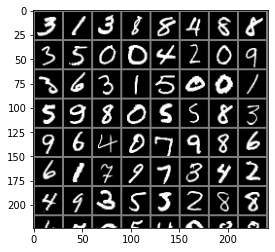

In [ ]:
images, labels = iter(train_loader).next()
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1,2,0)
std = [0.5]
mean = [0.5]
img = img*std+mean
for i in range(64//8):
  print([labels[8*i+j].tolist() for j in range(8)])
plt.imshow(img[:28*8])

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # zeroes the gradient buffers of all parameters
        optimizer.zero_grad()
        output = model(data)
        # loss = criterion(output, target)
        loss = criterion(output, target)
        
        loss.backward()
        # Perform the training parameters update
        optimizer.step()

        if (batch_idx + 1) % 30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx , len(train_loader),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss =0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            pred = output.max(1, keepdim = True)[1] # get the index whose value is the biggest
            correct += pred.eq(target.view_as(pred)).sum().item()

    
    test_loss /= len(test_loader.dataset)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) \n".format(
        test_loss, correct, len(test_loader.dataset),
        100.* correct / len(test_loader.dataset)
            ))

In [ ]:
model = Net()
model= model.to(DEVICE)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-3, momentum = 0.9) #regularization: weight_decay

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model,  DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [29/118 (25%)]	Loss: 2.088209
Train Epoch: 1 [59/118 (50%)]	Loss: 1.754573
Train Epoch: 1 [89/118 (75%)]	Loss: 1.343417

Test set: Average loss: 0.0021, Accuracy: 7933/10000 (79%) 

Train Epoch: 2 [29/118 (25%)]	Loss: 0.981476
Train Epoch: 2 [59/118 (50%)]	Loss: 0.760938
Train Epoch: 2 [89/118 (75%)]	Loss: 0.694245

Test set: Average loss: 0.0012, Accuracy: 8633/10000 (86%) 



### **Q3 Adding summaries to save the results (modification of the function train and test)**

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # zeroes the gradient buffers of all parameters
        optimizer.zero_grad()
        output = model(data)
        # loss = criterion(output, target)
        loss = criterion(output, target)
        writer.add_scalar('Loss/train', loss, epoch)
        loss.backward()
        # Perform the training parameters update
        optimizer.step()

        if (batch_idx + 1) % 30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx , len(train_loader),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss =0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            pred = output.max(1, keepdim = True)[1] # get the index whose value is the biggest
            correct += pred.eq(target.view_as(pred)).sum().item()

    writer.add_scalar('Accuracy/test', 100.*correct, epoch)
    test_loss /= len(test_loader.dataset)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) \n".format(
        test_loss, correct, len(test_loader.dataset),
        100.* correct / len(test_loader.dataset)
            ))

In [ ]:
model = Net()
model= model.to(DEVICE)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-3, momentum = 0.9) #regularization: weight_decay

In [ ]:
for epoch in range(1, EPOCHS + 1):
    writer = SummaryWriter('runs/MNIST_TEST')
    train(model,  DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)
    writer.close()
print(writer)

Train Epoch: 1 [29/118 (25%)]	Loss: 2.126001
Train Epoch: 1 [59/118 (50%)]	Loss: 1.803117
Train Epoch: 1 [89/118 (75%)]	Loss: 1.371762

Test set: Average loss: 0.0022, Accuracy: 8002/10000 (80%) 

Train Epoch: 2 [29/118 (25%)]	Loss: 0.895171
Train Epoch: 2 [59/118 (50%)]	Loss: 0.744648
Train Epoch: 2 [89/118 (75%)]	Loss: 0.652655

Test set: Average loss: 0.0012, Accuracy: 8633/10000 (86%) 



### **Q4 Convolutional neural network (CNN: Resnet18)**

**Manual Implementation de ResNet18 (change the number of channel in self.pre to cater to the datset)**

In [ ]:
# Definition of ResBlock
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, shortcut=None):
        super(ResBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(True),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        self.right = shortcut

    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)

# Definition of ResNet
class ResNet(nn.Module):
    def __init__(self,num_classes = 10):
        super(ResNet,self).__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, inchannel, outchannel, block_num, stride=1):
        shortcut = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
            nn.BatchNorm2d(outchannel))
        layers = []
        layers.append(ResBlock(inchannel, outchannel, stride, shortcut))
        for i in range(1, block_num):
            layers.append(ResBlock(outchannel, outchannel))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.pre(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 7)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out


In [ ]:
model = ResNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-3, momentum = 0.9) #regularization: weight_decay

**Import MINIST handwriting Dataset (Resize the images to shape (224,224) to cater to the need of ResNet)**

In [ ]:
transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5), std=(0.5))])
train_set = datasets.MNIST(root = "./data/", transform = transform, train = True, download = True)
test_set = datasets.MNIST(root = "./data/", transform = transform, train = False)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model,  DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [29/118 (25%)]	Loss: 0.275616
Train Epoch: 1 [59/118 (50%)]	Loss: 0.135754
Train Epoch: 1 [89/118 (75%)]	Loss: 0.092207

Test set: Average loss: 0.0002, Accuracy: 9627/10000 (96%) 

Train Epoch: 2 [29/118 (25%)]	Loss: 0.037107
Train Epoch: 2 [59/118 (50%)]	Loss: 0.029041
Train Epoch: 2 [89/118 (75%)]	Loss: 0.019859

Test set: Average loss: 0.0002, Accuracy: 9724/10000 (97%) 




### **Q5 Use of Optuna to find the best hyperparameters**

In [ ]:
!pip install optuna
import optuna

     |████████████████████████████████| 266kB 13.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 48.0MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
     |████████████████████████████████| 112kB 54.6MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 133kB 48.5MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=f1104f212e04daf01377034a216b1c54af91e72d436ca28bc7a982443814ad85
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=6fd6b7e64fb5d6ecafa7d56019cf25d47922416d1911a61a5f83383283f38dca
  Stored in directory: /root/.cache/pip/

In [ ]:
def objective(trial):

    model = ResNet().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    lr = trial.suggest_loguniform("lr", 1e-3, 10)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-3, 1)

    optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay, momentum = 0.9)

    # Training of the model.
    
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # # Limiting training data for faster epochs.
            # if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #     break
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                # if batch_idx * BATCHSIZE >= N_TEST_EXAMPLES:
                #     break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        # accuracy = correct / min(len(test_loader.dataset), N_TEST_EXAMPLES)
        accuracy = correct / len(test_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
search_space = {"lr": [1, 0.1, 0.01, 0.001], "weight_decay": [0.1, 0.01, 0.001]}
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space), direction="maximize")
study.optimize(objective, n_trials=12)


[I 2021-01-03 00:52:11,618] A new study created in memory with name: no-name-956c8c46-2170-4bef-8d36-b29a8b4fd7bb
[I 2021-01-03 00:58:47,354] Trial 0 finished with value: 0.0982 and parameters: {'lr': 1, 'weight_decay': 0.1}. Best is trial 0 with value: 0.0982.
[I 2021-01-03 01:05:24,464] Trial 1 finished with value: 0.1135 and parameters: {'lr': 1, 'weight_decay': 0.01}. Best is trial 1 with value: 0.1135.
[I 2021-01-03 01:12:09,961] Trial 2 finished with value: 0.8992 and parameters: {'lr': 0.01, 'weight_decay': 0.01}. Best is trial 2 with value: 0.8992.
[I 2021-01-03 01:18:54,090] Trial 3 finished with value: 0.3943 and parameters: {'lr': 0.1, 'weight_decay': 0.01}. Best is trial 2 with value: 0.8992.
[I 2021-01-03 01:25:26,179] Trial 4 finished with value: 0.1135 and parameters: {'lr': 0.1, 'weight_decay': 0.1}. Best is trial 2 with value: 0.8992.
[I 2021-01-03 01:32:11,549] Trial 5 finished with value: 0.966 and parameters: {'lr': 0.001, 'weight_decay': 0.01}. Best is trial 5 with